In [1]:
!pip install --upgrade transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 340.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.1
    Uninstalling transformers-4.53.1:
      Successfully uninstalled transformers-4.53.1
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 482.6 kB/s eta 0:00:00


In [11]:
import torch
import gc
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig, TrainingArguments, Trainer
from datasets import config, load_dataset
from datasets import load_dataset
import evaluate

import numpy
import time
from peft import LoraConfig, TaskType, get_peft_model
import os
import shutil
import matplotlib.pyplot as plt

In [4]:
# TODO: Load tokenizer and set pad_token
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a pad token, so we use eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [5]:
# TODO: Load model configuration and model
config = AutoConfig.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2", config=config)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
# Disable fsspec glob
os.environ["FSSPEC_DISABLE_GLOB"] = "1"
"""
# Clear cache
cache_dir = config.HF_DATASETS_CACHE
print(f"Clearing cache directory: {cache_dir}")
shutil.rmtree(cache_dir, ignore_errors=True)
"""
# TODO: Load SQuAD dataset and create train/validation splits
dataset = load_dataset("rajpurkar/squad", cache_dir="./squad_cache")
print("SQuAD dataset loaded successfully")
vali_ds = dataset["validation"].select(range(5))  # Select 5 examples for quick validation
split_ds = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_ds = split_ds["train"].shuffle(seed=42).select(range(2000))  # Select 2000 examples for training******************************************************************************2000
eval_ds = split_ds["test"].shuffle(seed=42).select(range(200))  # Select 200 examples for evaluation**********************************************************************************200

# Clear memory
del dataset, split_ds
gc.collect()

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

SQuAD dataset loaded successfully


328

In [9]:
def preprocess_function(examples):
    """
    Creates properly aligned input-label pairs for causal LM fine-tuning.

    Args:
        examples: Batch of SQuAD examples with 'context', 'question', 'answers'

    Returns:
        Dictionary with 'input_ids', 'attention_mask', 'labels' as PyTorch tensors
    """
    inputs = []
    for context, question, answers in zip(examples['context'], examples['question'], examples['answers']):
        answer_text = answers['text'][0] if answers['text'] else ""
        prompt = f"Context: {context}\nQuestion: {question}\nAnswer: "
        full_text = f"{prompt}{answer_text}{tokenizer.eos_token}"
        inputs.append(full_text)

    model_inputs = tokenizer(
        inputs,
        max_length=512,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    labels = []
    for i, input_ids in enumerate(model_inputs['input_ids']):
        label_ids = input_ids.clone()
        prompt_text = f"Context: {examples['context'][i]}\nQuestion: {examples['question'][i]}\nAnswer: "
        prompt_tokens = tokenizer(prompt_text, max_length=512, truncation=True, return_tensors="pt")['input_ids'][0]
        prompt_length = len(prompt_tokens)
        label_ids[:prompt_length] = torch.full((prompt_length,), -100, dtype=torch.long)
        labels.append(label_ids)

    model_inputs['labels'] = torch.stack(labels)
    return model_inputs


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Training examples: 2000
Eval examples: 200
Sample input_ids type: <class 'list'>
Sample input_ids shape: torch.Size([512])
trainable params: 1,622,016 || all params: 126,061,824 || trainable%: 1.2867
Trainable: base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight
Trainable: base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight
Trainable: base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight
Trainable: base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight
Trainable: base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight
Trainable: base_model.model.transformer.h.0.mlp.c_proj.lora_B.default.weight
Trainable: base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight
Trainable: base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight
Trainable: base_model.model.transformer.h.1.attn.c_proj.lora_A.default.weight
Trainable: base_model.model.transformer.h.1.attn.c_proj.lora_B.default.weight
Trainable: base_model.

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,No log,0.013086
2,2.812100,0.011455
3,2.812100,0.010311
4,0.015400,0.009429
5,0.013200,0.009060


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Results: {'config_id': 'config_r16_lr1e-4', 'r': 16, 'learning_rate': 0.0001, 'trainable_params': 1622016, 'training_time': 1242.481718301773, 'train_loss': [2.8121, 0.0154, 0.0132], 'eval_loss': [0.01308636274188757, 0.011454885825514793, 0.010311104357242584, 0.00942942127585411, 0.009060001000761986, 0.009060001000761986], 'f1': 1.904761904761905, 'exact_match': 0.0}
Evaluating baseline GPT-2 model...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Baseline Metrics: {'exact_match': 0.0, 'f1': 1.714546283629731}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Comparison with Baseline:
LoRA Config config_r16_lr1e-4: F1=1.90, EM=0.00
Baseline GPT-2: F1=1.71, EM=0.00

=== Testing Fine-tuned Model ===


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example 1:
Context: Super Bowl 50 was an American football game to determine the champion of the National Football Leagu...
Question: Which NFL team represented the AFC at Super Bowl 50?
Prediction: This is a question that has been asked many times over the past few years, and it is one that I would like to address in a future post. In this post, I will attempt to answer the question, "Which NFL teams represented each of
Ground Truth: Denver Broncos



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Example 2:
Context: Super Bowl 50 was an American football game to determine the champion of the National Football Leagu...
Question: Which NFL team represented the NFC at Super Bowl 50?
Prediction: The New England Patriots, New York Giants, Philadelphia Eagles, and Seattle Seahawks were the only NFL teams to win the championship. However, there were also two other teams that won the title: the New Orleans Saints and the Atlanta Falcons.  The
Ground Truth: Carolina Panthers

Example 3:
Context: Super Bowl 50 was an American football game to determine the champion of the National Football Leagu...
Question: Where did Super Bowl 50 take place?
Prediction: This is a question that has been asked many times over the years, and it is one that I am sure many of you will be asking yourself.  The answer to this question is that it took place at a time when the NFL and the
Ground Truth: Santa Clara, California



FileNotFoundError: [Errno 2] No such file or directory: 'plots/loss_curves.png'

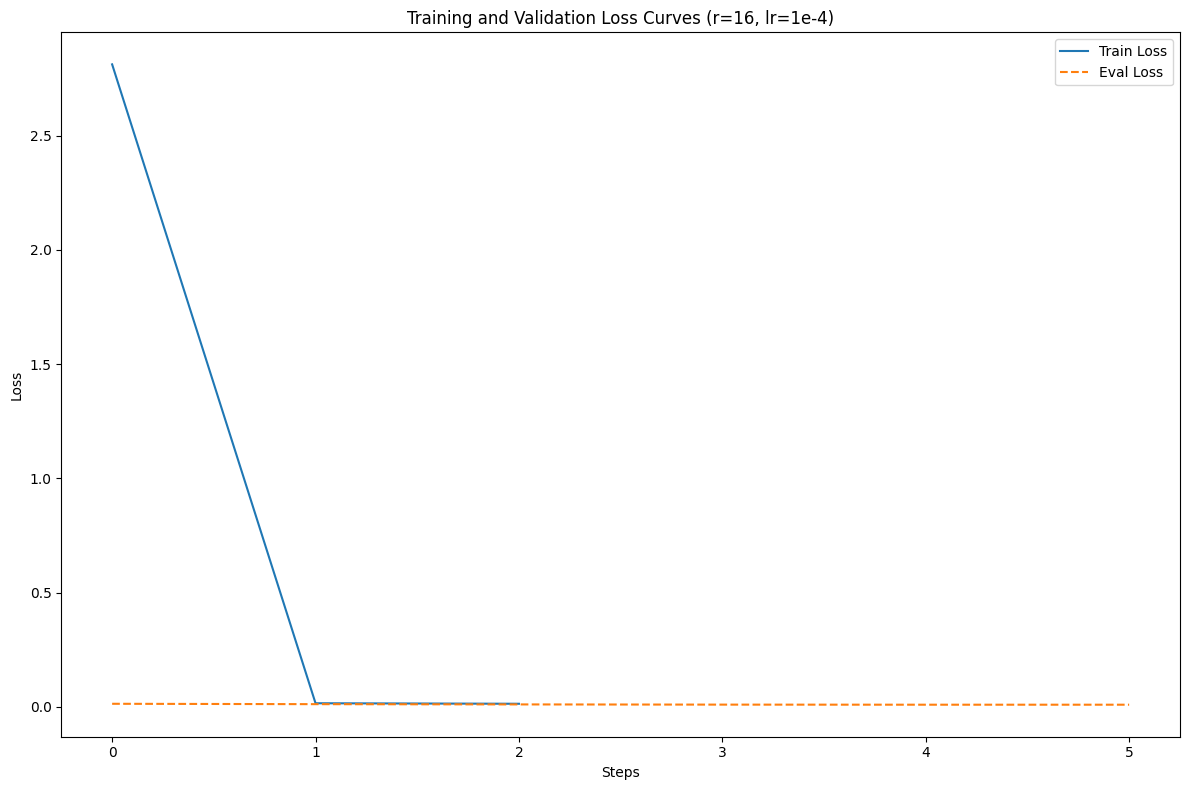

In [13]:
class QADataCollator:
    """
    Custom data collator for QA fine-tuning with proper padding
    """
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, features):
        """
        Batch sequences (already padded in preprocess_function)
        """
        input_ids = torch.stack([torch.tensor(f['input_ids']) if not isinstance(f['input_ids'], torch.Tensor) else f['input_ids'] for f in features])
        attention_mask = torch.stack([torch.tensor(f['attention_mask']) if not isinstance(f['attention_mask'], torch.Tensor) else f['attention_mask'] for f in features])
        labels = torch.stack([torch.tensor(f['labels']) if not isinstance(f['labels'], torch.Tensor) else f['labels'] for f in features])

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

# Apply preprocessing to datasets
tok_train_ds = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tok_eval_ds = eval_ds.map(preprocess_function, batched=True, remove_columns=eval_ds.column_names)

# Verify dataset output
print(f"Training examples: {len(tok_train_ds)}")
print(f"Eval examples: {len(tok_eval_ds)}")
print(f"Sample input_ids type: {tok_train_ds[0]['input_ids'].__class__}")
print(f"Sample input_ids shape: {torch.tensor(tok_train_ds[0]['input_ids']).shape}")

#rank
#r=4
#r=8
r=16
#r=32


# Define single LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=r,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["c_attn", "c_proj", "mlp.c_proj"],
    fan_in_fan_out=True
)

# Define single learning rate
learning_rate = 1e-4
#learning_rate = 2e-4
#learning_rate = 5e-4

def train_and_evaluate(lora_config, learning_rate, config_id):
    """
    Train and evaluate model with given LoRA configuration and learning rate.

    Args:
        lora_config: LoraConfig object
        learning_rate: Float learning rate
        config_id: String identifier for configuration

    Returns:
        Dictionary with training metrics and results
    """
    # Load model
    config = AutoConfig.from_pretrained("gpt2")
    model = AutoModelForCausalLM.from_pretrained("gpt2", config=config)

    # Freeze base model parameters
    for param in model.parameters():
        param.requires_grad = False

    # Create LoRA model
    lora_model = get_peft_model(model, lora_config)
    lora_model.print_trainable_parameters()

    # Store trainable parameters before deletion
    trainable_params = lora_model.get_nb_trainable_parameters()[0]

    # Verify LoRA setup
    for name, param in lora_model.named_parameters():
        if param.requires_grad:
            print(f"Trainable: {name}")

    lora_model.train()

    # Create training arguments with specified learning rate
    training_args = TrainingArguments(
        output_dir=f"./lora_qa_finetuning/{config_id}",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=learning_rate,
        num_train_epochs=5,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=100,
        gradient_accumulation_steps=4,
        max_grad_norm=1.0,
        save_total_limit=2,
        load_best_model_at_end=True,
        report_to="none"
    )

    # Create trainer
    trainer = Trainer(
        model=lora_model,
        args=training_args,
        train_dataset=tok_train_ds,
        eval_dataset=tok_eval_ds,
        data_collator=QADataCollator(tokenizer, max_length=512)
    )

    # Train model and measure time
    start_time = time.time()
    trainer.train()
    training_time = time.time() - start_time

    # Evaluate model
    evaluation_result = trainer.evaluate()

    # Generate predictions
    predictions = []
    references = []
    for example in vali_ds:
        context = example['context']
        question = example['question']
        ground_truth = example['answers']['text'][0] if example['answers']['text'] else ""
        prediction = generate_answer(lora_model, tokenizer, context, question)
        predictions.append({"id": example['id'], "prediction_text": prediction})
        references.append({"id": example['id'], "answers": example['answers']})

    squad_metric = evaluate.load("squad")
    metrics = squad_metric.compute(predictions=predictions, references=references)

    # Clean up memory
    del model
    del lora_model
    gc.collect()

    return {
        "config_id": config_id,
        "r": lora_config.r,
        "learning_rate": learning_rate,
        "trainable_params": trainable_params,
        "training_time": training_time,
        "train_loss": [log["loss"] for log in trainer.state.log_history if "loss" in log],
        "eval_loss": [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log],
        "f1": metrics["f1"],
        "exact_match": metrics["exact_match"]
    }

def generate_answer(model, tokenizer, context, question, max_new_tokens=50):
    """
    Generate answer for a given context and question
    """
    prompt = f"Context: {context}\nQuestion: {question}\nAnswer: "
    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        num_beams=5,
        no_repeat_ngram_size=2,
        early_stopping=True
    )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    answer_start = decoded.find("Answer: ") + len("Answer: ")
    return decoded[answer_start:].strip()

# Run single experiment
config_id = "config_r16_lr1e-4"
result = train_and_evaluate(lora_config, learning_rate, config_id)

# Print results
print(f"Results: {result}")


# Baseline Model Evaluation
print("Evaluating baseline GPT-2 model...")
baseline_model = AutoModelForCausalLM.from_pretrained("gpt2")
baseline_predictions = []
baseline_references = []
for example in vali_ds:
    context = example['context']
    question = example['question']
    ground_truth = example['answers']['text'][0] if example['answers']['text'] else ""
    prediction = generate_answer(baseline_model, tokenizer, context, question)
    baseline_predictions.append({"id": example['id'], "prediction_text": prediction})
    baseline_references.append({"id": example['id'], "answers": example['answers']})

squad_metric = evaluate.load("squad")
baseline_metrics = squad_metric.compute(predictions=baseline_predictions, references=baseline_references)
print(f"Baseline Metrics: {baseline_metrics}")

# Clean up baseline model
del baseline_model
gc.collect()

# Save fine-tuned model
lora_model = get_peft_model(AutoModelForCausalLM.from_pretrained("gpt2"), lora_config)
lora_model.save_pretrained("./model_checkpoints")
tokenizer.save_pretrained("./model_checkpoints")


# Print comparison
print("\nComparison with Baseline:")
print(f"LoRA Config {result['config_id']}: F1={result['f1']:.2f}, EM={result['exact_match']:.2f}")
print(f"Baseline GPT-2: F1={baseline_metrics['f1']:.2f}, EM={baseline_metrics['exact_match']:.2f}")

# Test on validation examples
print("\n=== Testing Fine-tuned Model ===")
for i, example in enumerate(vali_ds):
    if i >= 3:
        break
    context = example['context']
    question = example['question']
    ground_truth = example['answers']['text'][0] if example['answers']['text'] else ""
    prediction = generate_answer(lora_model, tokenizer, context, question)
    print(f"Example {i+1}:")
    print(f"Context: {context[:100]}...")
    print(f"Question: {question}")
    print(f"Prediction: {prediction}")
    print(f"Ground Truth: {ground_truth}\n")

# Plot: Training and Validation Loss Curves
plt.figure(figsize=(12, 8))
plt.plot(result["train_loss"], label="Train Loss")
plt.plot(result["eval_loss"], linestyle="--", label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves (r=16, lr=1e-4)")
plt.legend()
plt.tight_layout()
plt.savefig("plots/loss_curves.png")
plt.close()

# Clean up final model
del lora_model
gc.collect()